### 0.1 Check python version

In [1]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

### 0.2 Check that notebook server has access to all required resources, and that notebook has not moved

In [2]:
import os
nb_dirname = os.path.abspath("")
assignment_name = os.path.basename(nb_dirname)

import sys
sys.path.append("..")

### 0.3 Imports

In [86]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import random

from itertools import chain
from PIL import Image

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

# For splitting the data
from sklearn.model_selection import train_test_split
import shutil

### 0.4 Check for CUDA

In [4]:
print(f"CUDA is available:{torch.cuda.is_available()}") # test if gpu env is working

CUDA is available:False


### 1.1 Unzipping data

Only run this cell if you have not already unzipped and processed the data into correct folders

In [5]:
data_path = Path.cwd()
zip_file = data_path / "EC_dataset.zip"

# Check so that the .zip file excists
if not zip_file.exists():
    raise FileNotFoundError(
        "Download and place `{}` in the current directory (`{}`)".format(
            zip_file.name, data_path
        )
    )

# Folders from pre_existing_items will be deleted and we will start over from zip file: EC_dataset.zip
pre_existing_items = map(
    lambda x: data_path / Path(x),
    [
        "train",
        "validation",
        "test",
    ],
)

for item in pre_existing_items:
    if item.exists():
        # We need to use different functions for files and directories.
        if item.is_dir():
            shutil.rmtree(item)
        elif item.is_file():
            item.unlink()
        else:
            print("Unknown item: {}, remove manually".format(item))

# Unpacking the EC_dataset.zip into test and train
shutil.unpack_archive(zip_file, data_path)


### 1.2 Examining datasets

In [10]:
# Define the paths to the test and validation directories
train_dir = Path('train')
test_dir = Path('test')

# Function to count image files in a given directory and its subdirectories
def count_images_in_folder(directory):
    return len(list(directory.glob('**/*.*')))  # Adjust pattern to target specific file types (e.g., '*.jpg')

# Function to count images in each class subfolder
def count_images_in_classes(base_directory):
    class_counts = {}
    for class_dir in base_directory.iterdir():
        if class_dir.is_dir():
            class_counts[class_dir.name] = count_images_in_folder(class_dir)
    return class_counts

# Count images in 'train' and 'test' folders
train_image_count = count_images_in_folder(train_dir)
test_image_count = count_images_in_folder(test_dir)

# Count images in each class for train and test sets
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)

# Calculate total images
total_images = train_image_count + test_image_count

# Calculate percentages
train_percentage = (train_image_count / total_images) * 100 if total_images > 0 else 0
test_percentage = (test_image_count / total_images) * 100 if total_images > 0 else 0

# Print results for train set
print(f"Number of images in 'train': {train_image_count} ({train_percentage:.2f}%)")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / train_image_count) * 100:.2f}%)" 
                                 for class_name, count in train_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

W_training = [count for class_name, count in train_class_counts.items()] # used later as the dataset is not balanced

# Print results for test set
print(f"Number of images in 'test': {test_image_count} ({test_percentage:.2f}%)")
test_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / test_image_count) * 100:.2f}%)" 
                                      for class_name, count in test_class_counts.items()])
print(f"  Class counts: {test_class_counts_row}")

# Print total images
print(f"Total images: {total_images}")

Number of images in 'train': 28709 (80.00%)
  Class counts: angry: 3995 (13.92%) | disgusted: 436 (1.52%) | fearful: 4097 (14.27%) | happy: 7215 (25.13%) | neutral: 4965 (17.29%) | sad: 4830 (16.82%) | surprised: 3171 (11.05%)
Number of images in 'test': 7178 (20.00%)
  Class counts: angry: 958 (13.35%) | disgusted: 111 (1.55%) | fearful: 1024 (14.27%) | happy: 1774 (24.71%) | neutral: 1233 (17.18%) | sad: 1247 (17.37%) | surprised: 831 (11.58%)
Total images: 35887


We are missing a validation dataset, we will thus create one given from the test set. As we can see above, a class inbalance occurs. We do however have the same class inbalance for the test and train dataset, we want to keep this class inbalance for the validation set aswell

### 1.3 Creating Validation dataset by splitting test set

In [11]:
# Define paths
test_dir = Path('test')
validation_dir = Path('validation')
new_test_dir = Path('new_test')  # Temporary directory for the new test set

# Create the validation and new_test directories if they don't exist
validation_dir.mkdir(exist_ok=True)
new_test_dir.mkdir(exist_ok=True)

# Function to split a class folder into validation and new test set
def split_class_folder(class_name, source_folder, target_folder, validation_ratio=0.5):
    class_folder = source_folder / class_name
    images = list(class_folder.glob('*.*'))  # Adjust pattern to target specific file types (e.g., '*.jpg')
    random.shuffle(images)  # Shuffle the images to randomize selection

    # Calculate split index
    split_index = int(len(images) * validation_ratio)

    # Create target folders
    (target_folder / class_name).mkdir(parents=True, exist_ok=True)
    (validation_dir / class_name).mkdir(parents=True, exist_ok=True)

    # Move images to new test and validation directories
    for img in images[:split_index]:  # First half goes to validation
        shutil.move(str(img), str(validation_dir / class_name / img.name))

    for img in images[split_index:]:  # Second half goes to new test
        shutil.move(str(img), str(target_folder / class_name / img.name))

# Split each class folder in the test set
for class_folder in test_dir.iterdir():
    if class_folder.is_dir():
        split_class_folder(class_folder.name, test_dir, new_test_dir)

# Delete the old test directory
shutil.rmtree(test_dir)

# Rename new_test to test
new_test_dir.rename(test_dir)

# Count images in 'train', 'test', and 'validation' folders
train_image_count = count_images_in_folder(train_dir)
test_image_count = count_images_in_folder(test_dir)
validation_image_count = count_images_in_folder(validation_dir)  # Count images in validation folder

# Count images in each class for train, test, and validation sets
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)
validation_class_counts = count_images_in_classes(validation_dir)  # Count classes in validation

# Calculate total images
total_images = train_image_count + test_image_count + validation_image_count  # Include validation count

# Calculate percentages
train_percentage = (train_image_count / total_images) * 100 if total_images > 0 else 0
test_percentage = (test_image_count / total_images) * 100 if total_images > 0 else 0
validation_percentage = (validation_image_count / total_images) * 100 if total_images > 0 else 0  # Calculate validation percentage

# Print results for train set
print(f"Number of images in 'train': {train_image_count} ({train_percentage:.2f}%)")
class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / train_image_count) * 100:.2f}%)" 
                                 for class_name, count in train_class_counts.items()])
print(f"  Class counts: {class_counts_row}")

# Print results for test set
print(f"Number of images in 'test': {test_image_count} ({test_percentage:.2f}%)")
test_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / test_image_count) * 100:.2f}%)" 
                                      for class_name, count in test_class_counts.items()])
print(f"  Class counts: {test_class_counts_row}")

# Print results for validation set
print(f"Number of images in 'validation': {validation_image_count} ({validation_percentage:.2f}%)")
validation_class_counts_row = ' | '.join([f"{class_name}: {count} ({(count / validation_image_count) * 100:.2f}%)" 
                                            for class_name, count in validation_class_counts.items()])
print(f"  Class counts: {validation_class_counts_row}")


Number of images in 'train': 28709 (80.00%)
  Class counts: angry: 3995 (13.92%) | disgusted: 436 (1.52%) | fearful: 4097 (14.27%) | happy: 7215 (25.13%) | neutral: 4965 (17.29%) | sad: 4830 (16.82%) | surprised: 3171 (11.05%)
Number of images in 'test': 3591 (10.01%)
  Class counts: angry: 479 (13.34%) | disgusted: 56 (1.56%) | fearful: 512 (14.26%) | happy: 887 (24.70%) | neutral: 617 (17.18%) | sad: 624 (17.38%) | surprised: 416 (11.58%)
Number of images in 'validation': 3587 (10.00%)
  Class counts: angry: 479 (13.35%) | disgusted: 55 (1.53%) | fearful: 512 (14.27%) | happy: 887 (24.73%) | neutral: 616 (17.17%) | sad: 623 (17.37%) | surprised: 415 (11.57%)


### 1.4 Add class names to images in format: \<class_name\>.\<im_num\>.png

In [12]:
def rename_images_with_class_name(root_dir):
    """Rename images in subdirectories to include the class name.

    Args:
        root_dir (Path/str): The root directory containing 'train', 'validation', and 'test' folders.
    """
    root_dir = Path(root_dir)
    if not (root_dir.exists() and root_dir.is_dir()):
        raise ValueError(f"Data root '{root_dir}' is invalid")

    # Iterate through train, validation, and test directories
    for split in ['train', 'validation', 'test']:
        split_dir = root_dir / split
        if not split_dir.exists():
            continue

        # Iterate through each emotion subdirectory
        for emotion_dir in split_dir.iterdir():
            if emotion_dir.is_dir():
                
                # Iterate through images in the emotion directory
                for img_path in emotion_dir.glob("*.png"):  
                    
                    # Get the original image name without extension
                    original_name = img_path.stem
                    
                    # Create the new image name with the format: folder_name.original_name.png
                    new_name = f"{emotion_dir.name}.{original_name}.png"
                    new_path = emotion_dir / new_name
                    
                    # Rename the image
                    img_path.rename(new_path)

# Usage
rename_images_with_class_name(Path(os.path.abspath("")))  # Replace with your actual data root

### 1.5 Create dataset abstraction class

In [108]:
class EmotionsData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './emotion_data'
            transform (Compose): A composition of image transforms.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform

        # Define emotion labels and their corresponding indices
        self.emotion_labels = {
            "angry": 0,
            "disgusted": 1,
            "fearful": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprised": 6
        }


        # Collect samples and store pairs of (filepath, label) in a list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels for emotions

        Helper method for the constructor.
        """
        # Create an empty list to store all paths and labels
        all_paths_and_labels = []
        
        # Iterate over each emotion and its corresponding label
        for emotion, label in self.emotion_labels.items():
            
            # Collect paths for the current emotion
            emotion_paths = self._collect_imgs_sub_dir(self.root / emotion)
            
            # Map each path to the corresponding emotion label
            emotion_paths_and_labels = map(lambda path: (path, label), emotion_paths)
            
            # Add to the list of all paths and labels
            all_paths_and_labels.extend(emotion_paths_and_labels)
        
        # Sort the paths for consistency (by filename stem)
        return sorted(all_paths_and_labels, key=lambda x: x[0].stem)
            

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.png")

    
    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.

        Args:
            id_ (str): Image id, e.g. `emotion.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

### 1.6 Normalize and create dataset objects

In [109]:
# transform the data to tensor
transform = Compose([ToTensor()])

# create initial object for the training dataset
train_path = "./train"
train_dataset = EmotionsData(train_path, transform = transform)

validation_path = "./validation"
validation_dataset = EmotionsData(validation_path, transform = transform)

test_path = "./test"
test_dataset = EmotionsData(test_path, transform = transform)

In [110]:
def calculate_mean_std(dataset):
    """
    Returns:
    - mean: A tensor representing the mean of the dataset.
    - std: A tensor representing the standard deviation of the dataset.
    """
    
    # Stack all images into a single tensor
    all_images = torch.stack([img_tensor for img_tensor, _ in dataset])

    # Calculate mean and std
    mean = all_images.mean(dim=[0, 2, 3])  # Average over batch, height, and width
    std = all_images.std(dim=[0, 2, 3])    # Standard deviation over batch, height, and width

    return mean, std


In [114]:

print(calculate_mean_std(train_dataset))
print(calculate_mean_std(validation_dataset))
print(calculate_mean_std(test_dataset))

# Calculating the mean and std of the training dataset
train_mean, train_std = calculate_mean_std(train_dataset)

# New transform including normalization
transformation_w_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,  
                         std=std)   
])

# Crearting normalized datasets
n_train_dataset = EmotionsData(train_path, transform = transformation_w_norm)
print(train_dataset[100][0])
print(n_train_dataset[100][0])


n_validation_dataset = EmotionsData(validation_path, transform = transformation_w_norm)


n_test_dataset = EmotionsData(test_path, transform = transformation_w_norm)

# Format: train_dataset[element][ 0 = img_tensor, 1 = label], label is decided from self.emotion_labels in the EmotionsData class
#print(train_dataset[0][0])


# Length of datasets
#print(len(train_dataset))
#print(len(validation_dataset))
#print(len(test_dataset))

(tensor([0.5077]), tensor([0.2550]))
(tensor([0.5057]), tensor([0.2559]))
(tensor([-0.0053]), tensor([1.0011]))
tensor([[[0.2353, 0.2392, 0.2392,  ..., 0.5765, 0.5922, 0.4745],
         [0.2275, 0.2549, 0.2431,  ..., 0.5804, 0.6039, 0.5961],
         [0.2392, 0.2667, 0.3020,  ..., 0.5255, 0.6078, 0.6392],
         ...,
         [0.6471, 0.5412, 0.4824,  ..., 0.4314, 0.4941, 0.4314],
         [0.5922, 0.4941, 0.4863,  ..., 0.4275, 0.5098, 0.4627],
         [0.5608, 0.4510, 0.4706,  ..., 0.4667, 0.4392, 0.5529]]])
tensor([[[-1.0683, -1.0529, -1.0529,  ...,  0.2697,  0.3312, -0.1302],
         [-1.0990, -0.9914, -1.0375,  ...,  0.2851,  0.3773,  0.3466],
         [-1.0529, -0.9452, -0.8068,  ...,  0.0698,  0.3927,  0.5157],
         ...,
         [ 0.5465,  0.1313, -0.0994,  ..., -0.2993, -0.0533, -0.2993],
         [ 0.3312, -0.0533, -0.0840,  ..., -0.3147,  0.0083, -0.1763],
         [ 0.2082, -0.2224, -0.1455,  ..., -0.1609, -0.2686,  0.1774]]])


### 1.7 Display image from each class

TRAIN DATASET IMAGES


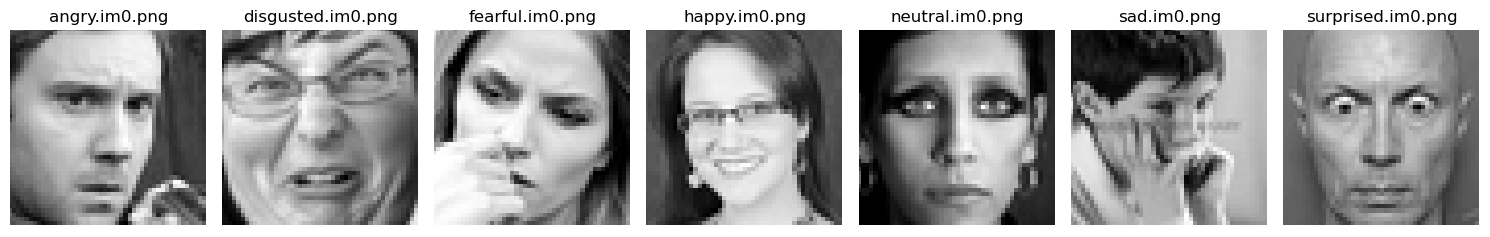

VALIDATION DATASET IMAGES


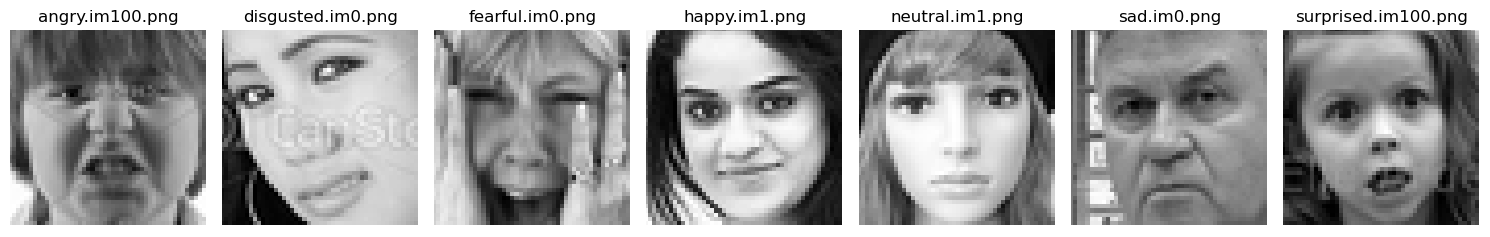

TEST DATASET IMAGES


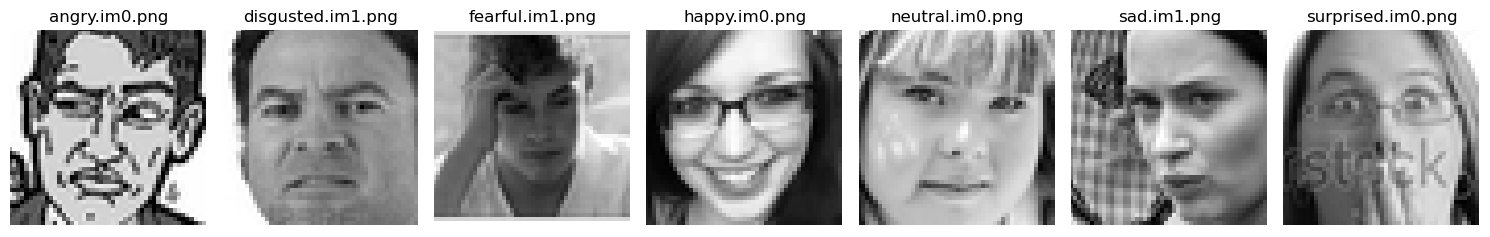

In [115]:
def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels, width, height)
    """
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor`, "
            "use the `ToTensor` transformation to convert the images to tensors."
        )

    # Check if the tensor is grayscale
    if image_tensor.size(0) == 1:
        # Grayscale image (shape: [1, height, width])
        image_data = image_tensor.squeeze(0).numpy()  # Remove the channel dimension
        axis.imshow(image_data, cmap='gray')  # Display as grayscale
    else:
        raise ValueError(f"Unsupported image shape: {image_tensor.size()}")

    # Set limits for the axes
    height, width = image_data.shape[:2]
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)  # Switch the y-limits to start from the top
    axis.axis('off')  # Turn off axis labels for a cleaner look

def show_sample_images(dataset):
    """Display one image from each emotion class.

    Args:
        dataset: Instance of your EmotionsDataset class.
    """
    fig, axes = plt.subplots(1, len(dataset.emotion_labels), figsize=(15, 5))

    for i, (emotion, label) in enumerate(dataset.emotion_labels.items()):
        # Find the first image for each emotion class in the dataset samples
        for img_path, img_label in dataset._samples:
            if img_label == label:
                # Load the image using the same logic as in your __getitem__ method
                img = Image.open(img_path)

                # Apply transformations if any
                if dataset.transform is not None:
                    img = dataset.transform(img)
                
                # Display the image on the respective axis
                display_image(axes[i], img)

                axes[i].set_title(img_path.name)
                break

    plt.tight_layout()
    plt.show()

print("TRAIN DATASET IMAGES")
show_sample_images(n_train_dataset)

print("VALIDATION DATASET IMAGES")
show_sample_images(n_validation_dataset)

print("TEST DATASET IMAGES")
show_sample_images(n_test_dataset)